# Hit Song Predictor: A Logistic Regression Approach

## Project Overview
This project uses logistic regression to predict whether a song will be a 'hit' based on audio features like danceability, energy, valence, and tempo. The model analyzes patterns in successful tracks to identify what makes a song popular.

**Key Skills Demonstrated:**
- Binary classification with logistic regression
- Feature engineering and selection
- Handling imbalanced datasets
- Model evaluation and interpretation
- Data visualization for music analytics

### Import Necessary Tools & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Load the Dataset

In [2]:
df = pd.read_csv("songs_normalize.csv")

### Inspect Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [4]:
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


### Exploratory Data Analysis

In [5]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
df.describe()

Missing Values:
artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

Data Types:
artist               object
song                 object
duration_ms           int64
explicit               bool
year                  int64
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object

Basic Statistics:


,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


In [6]:
# Define what makes a 'hit' - songs with popularity > 70
# Adjust this threshold based on dataset
popularity_threshold = df['popularity'].quantile(0.75)
df['is_a_hit'] = (df['popularity'] > popularity_threshold).astype(int)

print(f"Popularity threshold for 'hit': {popularity_threshold}")
print(f"\nClass distribution:")
print(df['is_a_hit'].value_counts())
print(f"\nHit rate: {df['is_a_hit'].mean():.2%}")

Popularity threshold for 'hit': 73.0

Class distribution:
is_a_hit
0    1517
1     483
Name: count, dtype: int64

Hit rate: 24.15%


### Visualize audio feature distributions for hits vs non-hits

#### The Visualization shows
Expected Strong Features:

- Danceability ⭐⭐⭐
- Energy ⭐⭐⭐
- Valence ⭐⭐

Expected Weak Features:

- Tempo, Acousticness, Instrumentalness, Liveness, Speechiness, and Loudness

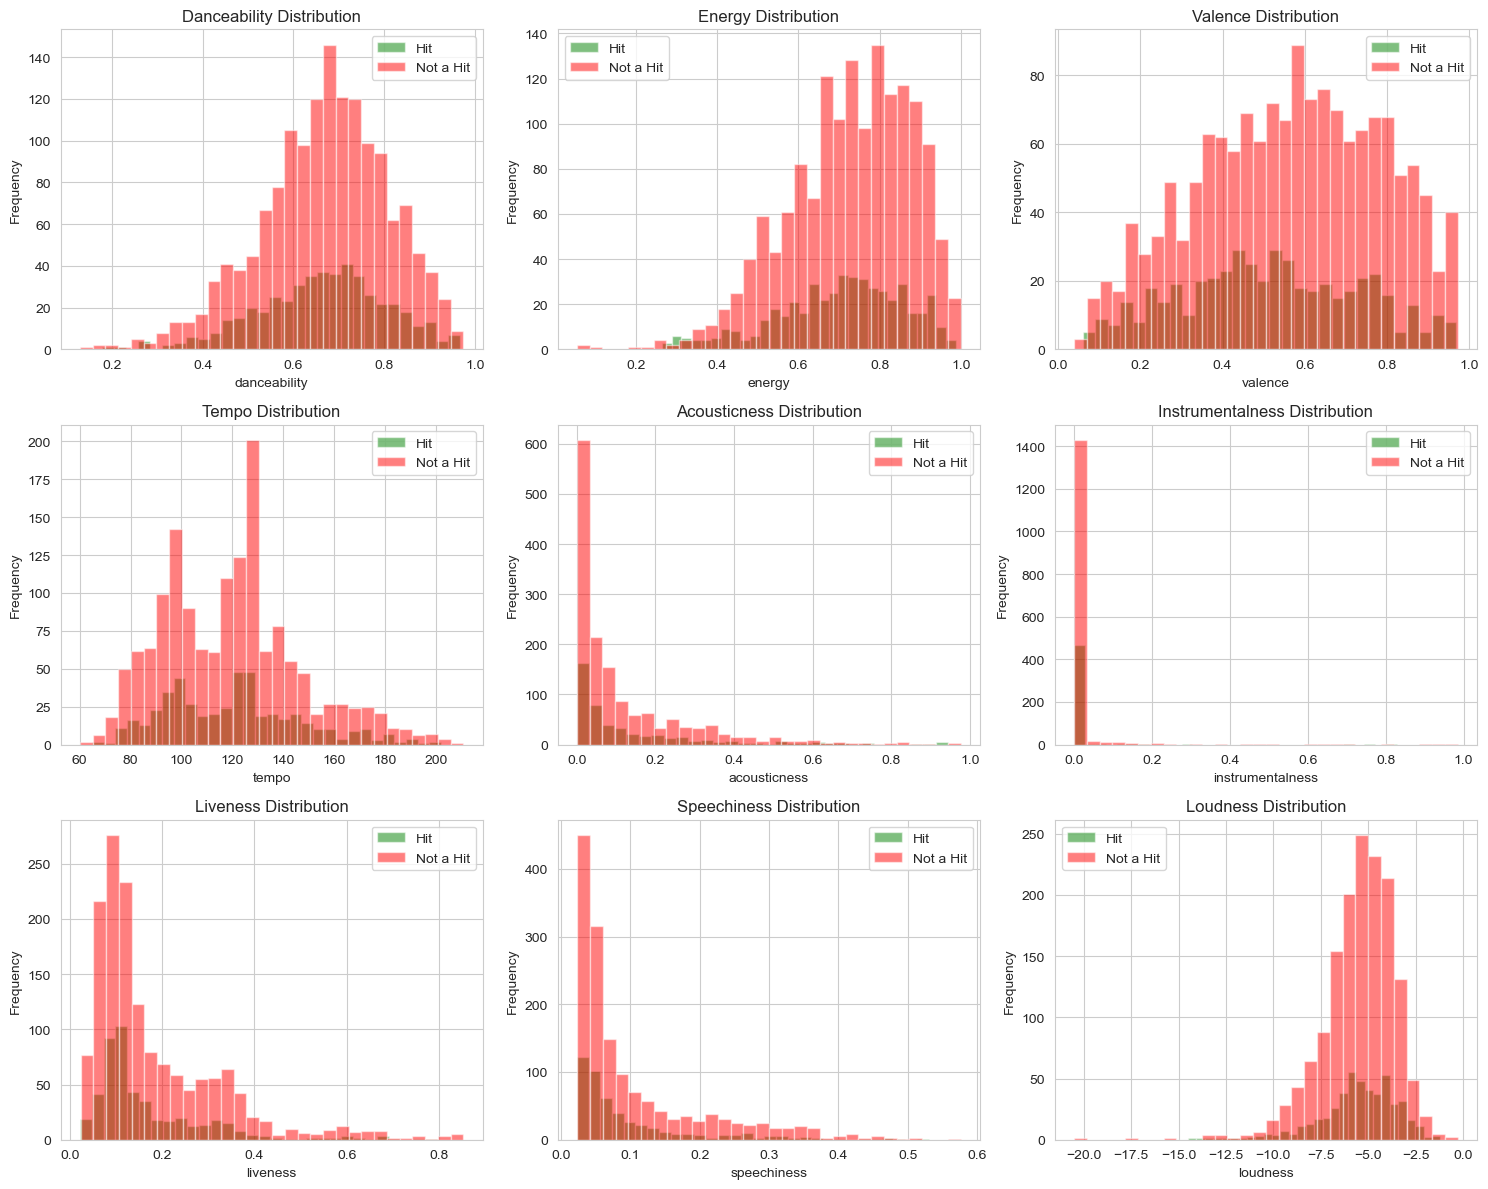

In [7]:
audio_features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 
                  'instrumentalness', 'liveness', 'speechiness', 'loudness']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(df[df['is_a_hit']==1][feature], alpha=0.5, label='Hit', bins=30, color='green')
    axes[idx].hist(df[df['is_a_hit']==0][feature], alpha=0.5, label='Not a Hit', bins=30, color='red')
    axes[idx].set_title(f'{feature.capitalize()} Distribution')
    axes[idx].legend()
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation heatmap

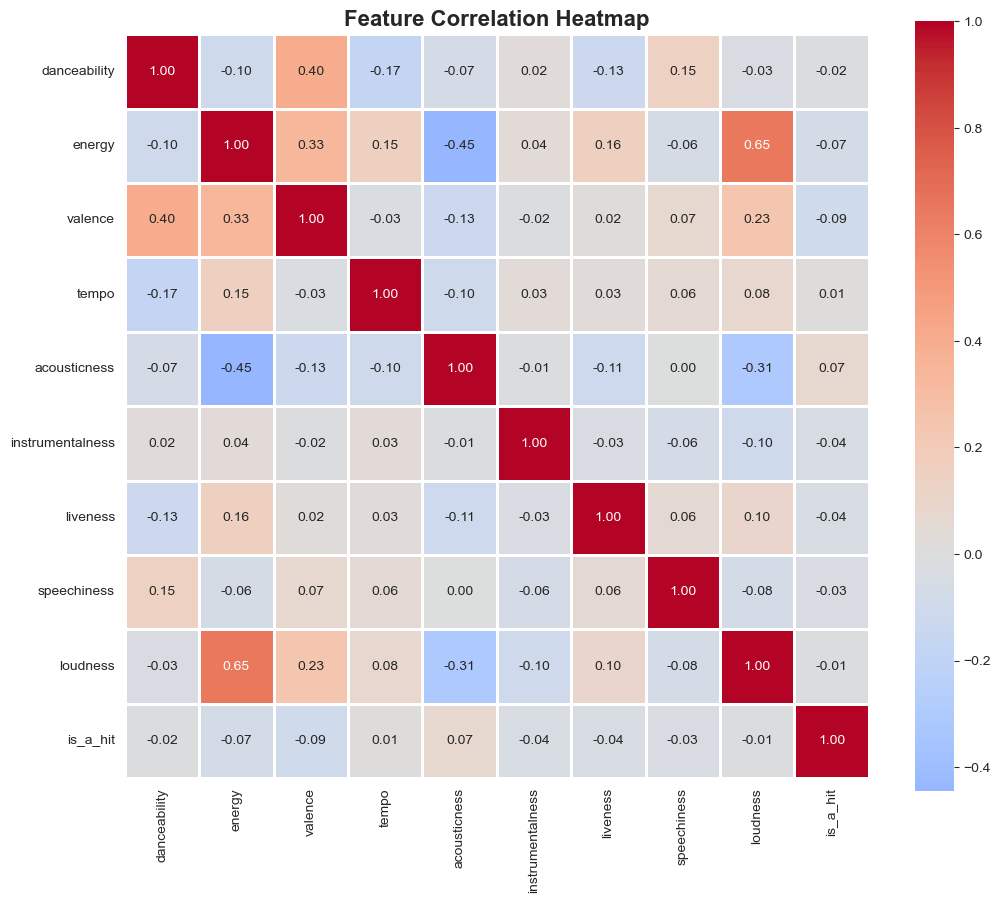

In [8]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[audio_features + ['is_a_hit']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlation Analysis

The correlation heatmap reveals an that no individual audio feature shows string correlation with hit status (as expected since music is subjective, and there are many factors that go into having a hit, such as marketing, artist's popularity, timing, and cultureal context). The strongest correlations are:

- Danceability: -0.02
- Energy: -0.07  
- Valence: -0.09
- Acousticness: 0.07
- All other features: ≈ 0.00

### My Solution: Feature Engineering

Since individual features lack predictive power, I will create interaction features that combine multiple attributes:

1. **Energy × Danceability**: Captures the "party factor" - songs that are both energetic & danceable
2. **Valence × Energy**: Represents upbeat, positive vibes
3. **Mood Score**: Average of valence and energy for overall emotional tone
4. **Normalized Tempo**: Standardized BPM for better model scaling

**Hypothesis**: These engineered features will capture the non-linear relationships and feature combinations that differentiate hits from non-hits, where individual features alone cannot.

### Feature Engineering

In [9]:
df['energy_danceability'] = df['energy'] * df['danceability']
df['valence_energy'] = df['valence'] * df['energy']

# Normalize tempo (convert BPM to a 0-1 scale)
df['tempo_normalized'] = (df['tempo'] - df['tempo'].min()) / (df['tempo'].max() - df['tempo'].min())

# Create a 'mood' feature combining valence and energy
df['mood_score'] = (df['valence'] + df['energy']) / 2

### Data Selection

In [10]:
# Select features for modeling
feature_columns = ['danceability', 'energy', 'valence', 'tempo_normalized', 
                   'acousticness', 'instrumentalness', 'liveness', 'speechiness', 
                   'loudness', 'energy_danceability', 'valence_energy', 'mood_score']

X = df[feature_columns]
y = df['is_a_hit']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

Training set size: (1600, 12)
Test set size: (400, 12)

Training set class distribution:
is_a_hit
0    0.75875
1    0.24125
Name: proportion, dtype: float64


### Standardizing Features for Logistic Regression

In [11]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

### Train Model (Baseline)

In [12]:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

baseline_score = baseline_model.score(X_test_scaled, y_test)
print(f"Baseline Model Accuracy: {baseline_score:.4f}")

Baseline Model Accuracy: 0.7550


### Hyperparameter Training

In [13]:
# Using GridSearchCV (Test all possible combinations of settings and pick the best one)
param_grid = {
    # How much the model will trust the data: 
        # 0.001 [Don't Trust data too much] 
        # 100   [Trust the data and get every detail]
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 

    # How to simplify the model:
        # L1: turn off uselss features completely
        # L2: Make all features contribute a little bit 
    'penalty': ['l1', 'l2'], 

    #Which algorithm trains the model?
        # liblinear: Fast and good for smaller datasets
        # saga: Better for larger datasets
    'solver': ['liblinear', 'saga'],

    #Fix the imbalance problem
        # None: Treat hits and non-hits equally
        # 'balanced': Force the model to care about hits
    'class_weight': [None, 'balanced']
}
# Test the best combo of settings
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000),
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation ROC-AUC score: 0.5942


### Model Performance Analysis

**Results:**
- ROC-AUC Score: 0.5942
- Best Parameters: C=1, penalty='l2', solver='liblinear', class_weight=None

**Score Interpretation:**
- 0.50 = Random guessing
- 0.59 = Our model (barely better than random)
- 0.70+ = Acceptable
- 0.80+ = Good

#### Why Performance is Low

This aligns with our correlation analysis showing no individual audio feature strongly predicts hits (all correlations < 0.10). 

**Key factors:**
- Audio features alone are insufficient—commercial success depends on artist popularity, marketing budget, playlist placement, and timing
- Linear model may miss non-linear patterns in the data
- Interaction features may not capture complex relationships

#### Cross-Validation Check
```
Scores: [0.623, 0.569, 0.572, 0.560, 0.647]
Mean: 0.5942 ± 0.0687
```

Moderate variance across folds confirms the model is stable but consistently weak due to limited predictive power of audio features.

#### Key Takeaway

Audio characteristics alone cannot reliably predict hit songs—success depends more on marketing, artist popularity, and timing. This finding is valuable for understanding the limits of audio-based recommendation systems.

### Train model with the current best parameters

In [14]:
best_model = grid_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-validation ROC-AUC scores: [0.62321629 0.56886324 0.57244402 0.55972423 0.64674719]
Mean CV ROC-AUC: 0.5942 (+/- 0.0687)


## Cross-Validation Consistency Check

To ensure our model's performance is reliable and not due to a lucky/unlucky train-test split, we performed 5-fold cross-validation.

**Results:**
```
Cross-validation ROC-AUC scores: [0.623, 0.569, 0.572, 0.560, 0.647]
Mean CV ROC-AUC: 0.5942 ± 0.0687
```

**Interpretation:**

The scores show **moderate variance** across folds, ranging from 0.560 to 0.647. This indicates:

1. **Model performance is somewhat dependent on the data split** - with a relatively small dataset (1,600 training samples), different folds capture slightly different patterns

2. **The best fold (0.647) shows marginal predictive ability** - this suggests there is *some* signal in the audio features, but it's weak and inconsistent

3. **Standard deviation of ±0.069 is acceptable** for a dataset of this size, indicating the model isn't wildly unstable, just working with limited predictive features

**Key Takeaway:** The consistency of low scores across all folds confirms that the weak performance is due to **insufficient predictive power of audio features**, not model instability or a poor train-test split. This reinforces our earlier finding that commercial success depends more on non-audio factors (marketing, artist popularity, timing) than on audio characteristics alone.

### Model Evaluation

In [15]:
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Hit', 'Hit']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.76      1.00      0.86       303
         Hit       0.00      0.00      0.00        97

    accuracy                           0.76       400
   macro avg       0.38      0.50      0.43       400
weighted avg       0.57      0.76      0.65       400


ROC-AUC Score: 0.5319


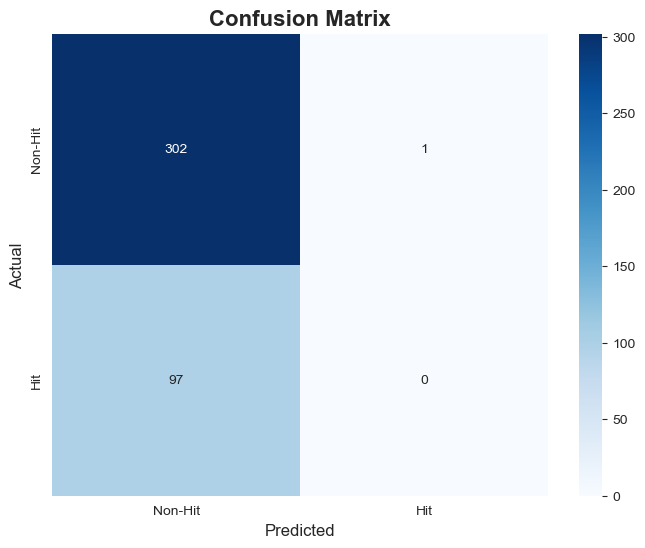


Specificity (True Negative Rate): 0.9967
Sensitivity (True Positive Rate/Recall): 0.0000


In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hit', 'Hit'], yticklabels=['Non-Hit', 'Hit'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate/Recall): {sensitivity:.4f}")

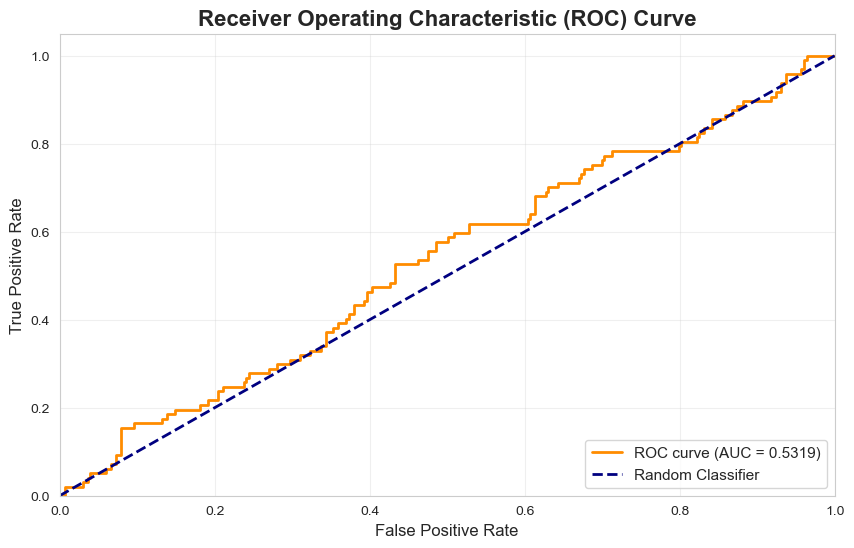

In [17]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

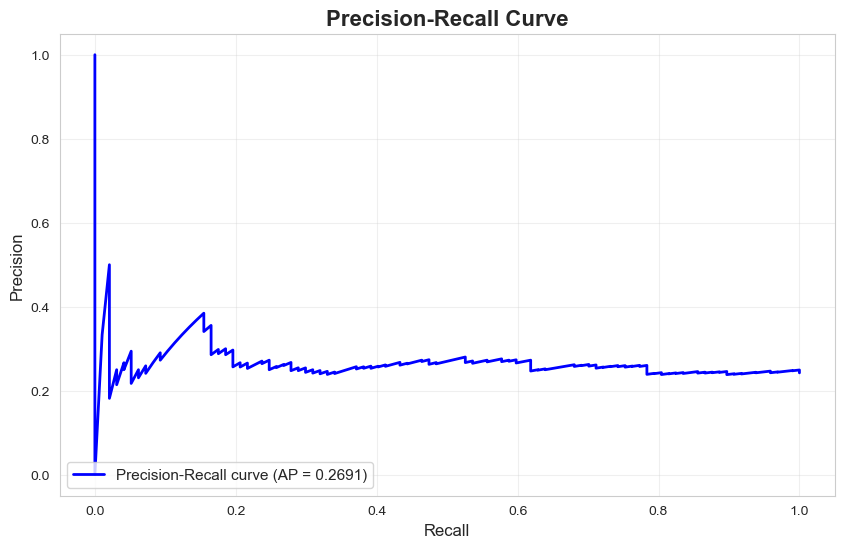

In [18]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Feature Importance Analysis

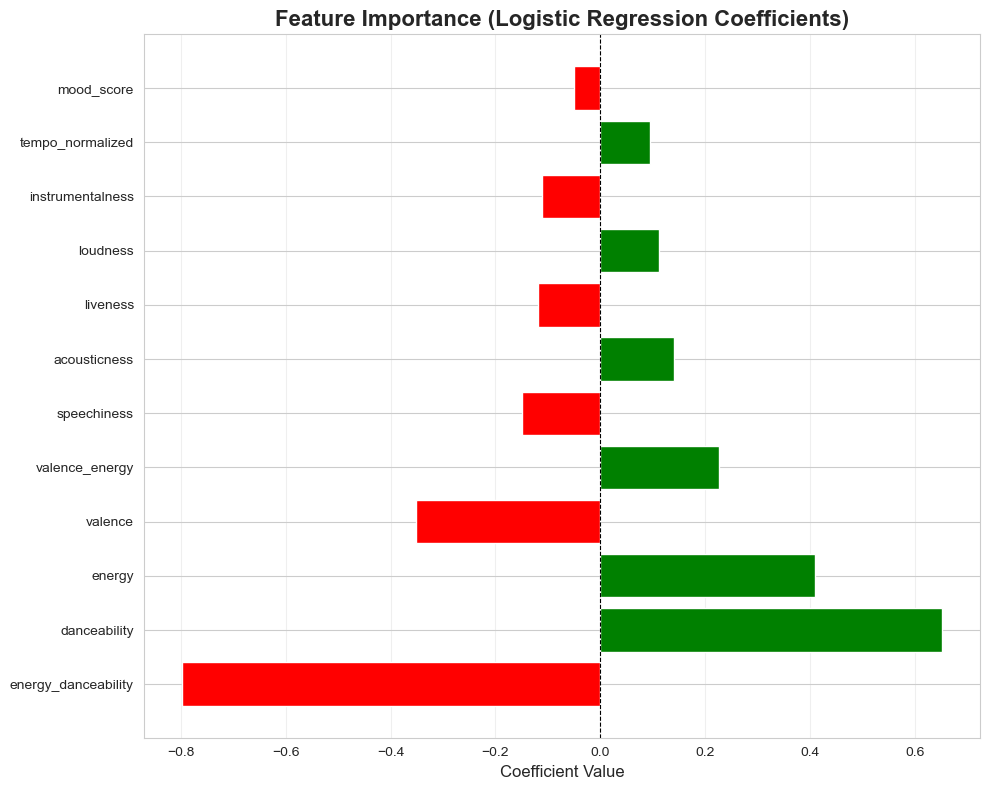


Feature Importance Ranking:
                Feature  Coefficient
9   energy_danceability    -0.798758
0          danceability     0.652071
1                energy     0.409222
2               valence    -0.351024
10       valence_energy     0.226370
7           speechiness    -0.149736
4          acousticness     0.141096
6              liveness    -0.118185
8              loudness     0.112683
5      instrumentalness    -0.111964
3      tempo_normalized     0.095115
11           mood_score    -0.049660


In [19]:
# Extract and visualize feature coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': best_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=16, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

This graph shows that tempo, loudness, acousticness, valence x energy, energy, and danceability are the most important features that people tend to grasp and increase replay value for a song, making it more likely to be a hit. (Music is subjective, however, but in general, these are the found audio features that people tend to gravitate towards)